In [174]:
#importing the libraries
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
import nltk
import re
import os
import mpld3
import codecs
from sklearn import feature_extraction
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [2]:
# keyword extraction https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34

dataset = pd.read_csv("GustavoDeco_100papers.csv", usecols = ["Cites", "Title", "Year", "Branch", "Key words", "Abstract" ] )
dataset.head()

Cites                                              Title  Year  \
0   1118  Emerging concepts for the dynamical organizati...  2011   
1    794  The Dynamic Brain: From Spiking Neurons to Neu...  2008   
2    539  Key role of coupling, delay, and noise in rest...  2009   
3    437  Ongoing Cortical Activity at Rest: Criticality...  2012   
4    370  Stochastic dynamics as a principle of brain fu...  2009   

                                     Branch  \
0  Computational and Cognitive Neuroscience   
1  Computational and Cognitive Neuroscience   
2  Computational and Cognitive Neuroscience   
3  Computational and Cognitive Neuroscience   
4  Computational and Cognitive Neuroscience   

                                           Key words  \
0  Resting state fMRI, Psychology, Neuroscience, ...   
1  Working memory, Neuroscience, Mathematical the...   
2  Synchronization, Stochastic resonance, Statist...   
3  Resting state fMRI, Neuroscience, Multistabili...   
4  Recall, Probabilistic logic, Neuroscience, Neu...   

                                            Abstract  
0  A broad body of experimental work has demonstr...  
1  The cortex is a complex system, characterized ...  
2  A growing body of neuroimaging research has do...  
3  The ongoing activity of the brain at rest, i.e...  
4  The relatively random spiking times of individ...

In [3]:
# Storing the useful data from the csv into variables
citations = dataset['Cites'][:].astype(str)
titles = dataset['Title'][:].astype(str)
years = dataset['Year'][:].astype(str)
branches = dataset['Branch'][:].astype(str)
keywords = dataset['Key words'][:].astype(str)
abstracts = dataset['Abstract'][:].astype(str)

In [4]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')
#print (stopwords[:10] )
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [5]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed


#tokenize_and_stem: tokenizes (splits the abstracts into a list of its respective words (or tokens) and also stems each token
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems



#tokenize_only: tokenizes the synopsis only
def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [76]:
# Using the stemming/tokenizing functions to iterate through the abstracts to create 2 vocabularies: one stemmed and one tokenized

#not super pythonic, no, not at all.
#use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []

for i in keywords: #<------ KEYWORDS 
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'keywords', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [77]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print ('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')
print(vocab_frame)

there are 1857 items in vocab_frame
                   words
rest             resting
state              state
fmri                fmri
psycholog     psychology
neurosci    neuroscience
...                  ...
approxim   approximation
atom              atomic
physic           physics
angular          angular
distribut   distribution

[1857 rows x 1 columns]


In [78]:
# Tf-idf and document similarity

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(keywords) #fit the vectorizer to synopses

#print(tfidf_matrix.shape)

terms = tfidf_vectorizer.get_feature_names()

print(tfidf_matrix.shape)


dist = 1 - cosine_similarity(tfidf_matrix)

CPU times: user 181 ms, sys: 7.18 ms, total: 188 ms
Wall time: 187 ms
(100, 17)


/usr/local/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [84]:
# K-means clustering 
from sklearn.cluster import KMeans

num_clusters = 5  #<------------- estimating the number of clusters *****

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 118 ms, sys: 2.62 ms, total: 121 ms
Wall time: 119 ms


In [85]:
from sklearn.externals import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle

joblib.dump(km,  'doc_cluster.pkl')  ##<------- uncomment for first time

km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [86]:
citations = dataset['Cites'][:].astype(str)
titles = dataset['Title'][:].astype(str)
years = dataset['Year'][:].astype(str)
branches = dataset['Branch'][:].astype(str)
keywords = dataset['Key words'][:].astype(str)
abstracts = dataset['Abstract'][:].astype(str)

papers = { 'cites': citations, 'titles': titles, 'years': years, 'branches': branches, 'keywords': keywords, 'abstracts': abstracts, 'cluster':clusters }

# I left out the years and the abstracts
frame = pd.DataFrame(papers, index = [clusters] , columns = ['cites', 'titles', 'years', 'branches', 'keywords', 'cluster'])

In [87]:
frame['cluster'].value_counts() #<------- number of papers per cluster (clusters from 0 to 4)


2    30
4    24
1    21
3    16
0     9
Name: cluster, dtype: int64

In [89]:
# Printing the top keywords per cluster 

# from __future__ import print_function

print("Top terms per cluster:")
print()

#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    
   # print("Cluster %d titles:" % i, end='')
  #  for title in frame.ix[i]['titles'].values.tolist():
   #     print(' %s,' % titles, end='')
   # print() #add whitespace
   # print() #add whitespace
    
print()
print()

Top terms per cluster:

Cluster 0 words: b'biology', b'neuroscience', b'cortex', b'neural', b'networks', b'model',

Cluster 1 words: b'physics', b'state', b'functional', b'computer', b'science', b'networks',

Cluster 2 words: b'artificial', b'networks', b'intelligence', b'artificial', b'computer', b'neural',

Cluster 3 words: b'brain', b'networks', b'state', b'psychology', b'neuroscience', b'functional',

Cluster 4 words: b'psychology', b'cortex', b'neuroscience', b'cognitive', b'functional', b'networks',





/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app


In [90]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

In [92]:
# I define some dictionaries for going from cluster number to color and to cluster name. 
# I based the cluster names off the words that were closest to each cluster centroid.


#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names u
cluster_names = {0: 'aritificial, intelligence, neural, network', 
                 1: 'cognition, cognitive, attention, psychology', 
                 2: 'brains, connectivity, connectome, dynamical',
                 3: 'physics, theoretical, ion, electron',
                 4: 'stochastic, matrix, mathematics, model'} 


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


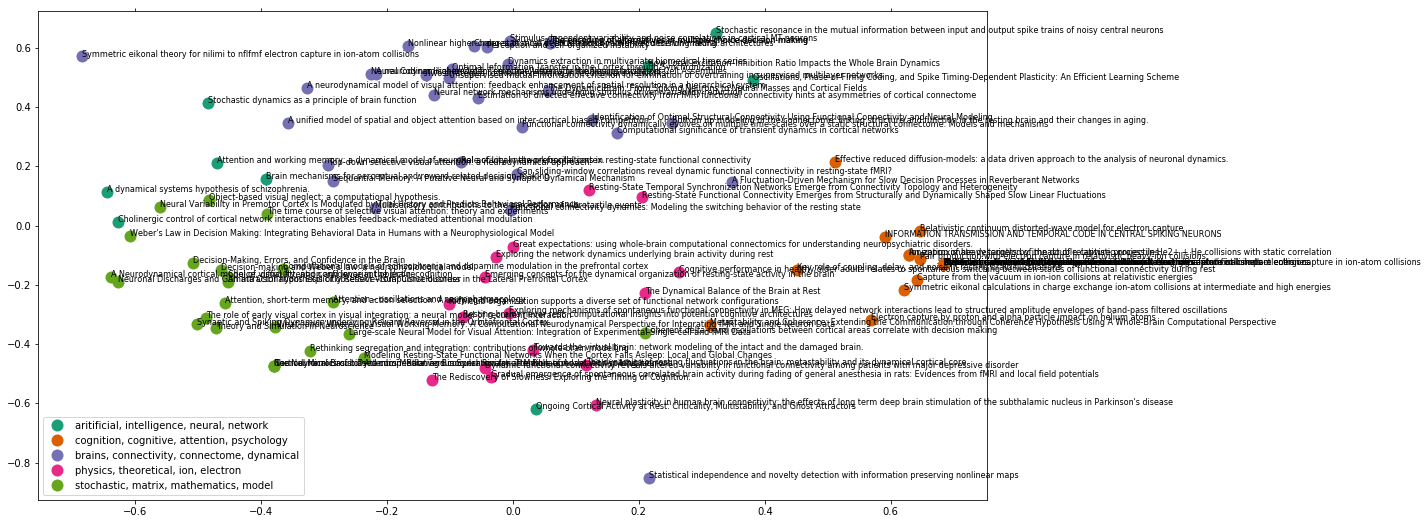

In [93]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  #<---- df.ix['title']

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

plt.close()

In [94]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [161]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(12,5)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, 
                     label=cluster_names[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)

In [145]:
# Converting series to list for using as my labels

list_titles = titles.values.tolist()
#print(list_titles) # now transformed into a list 

list_years = years.values.tolist()
#print(list_years)

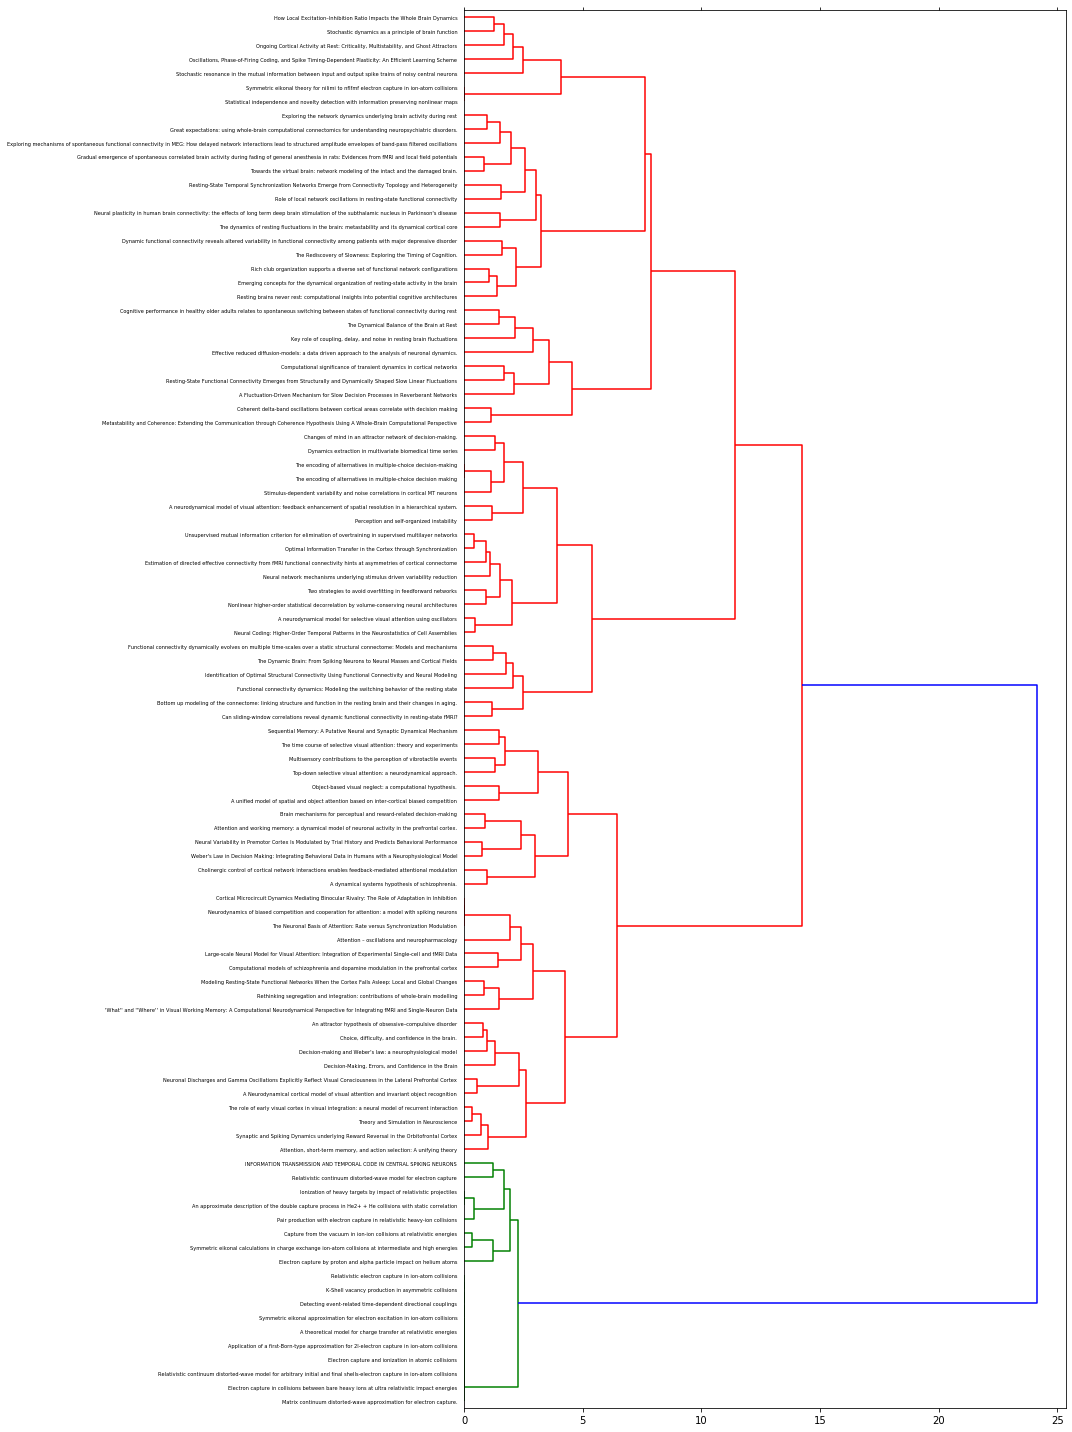

In [121]:
# Using keywords

# http://brandonrose.org/clustering#K-means-clustering
# The height in the dendrogram at which two clusters are merged 
# represents the distance between two clusters in the data space.

# Using wards and keywords
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=list_titles); #<--- issue with labels, they're too long

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('GustavoDeco_labtree.png', dpi=200) #save figure as ward_clusters

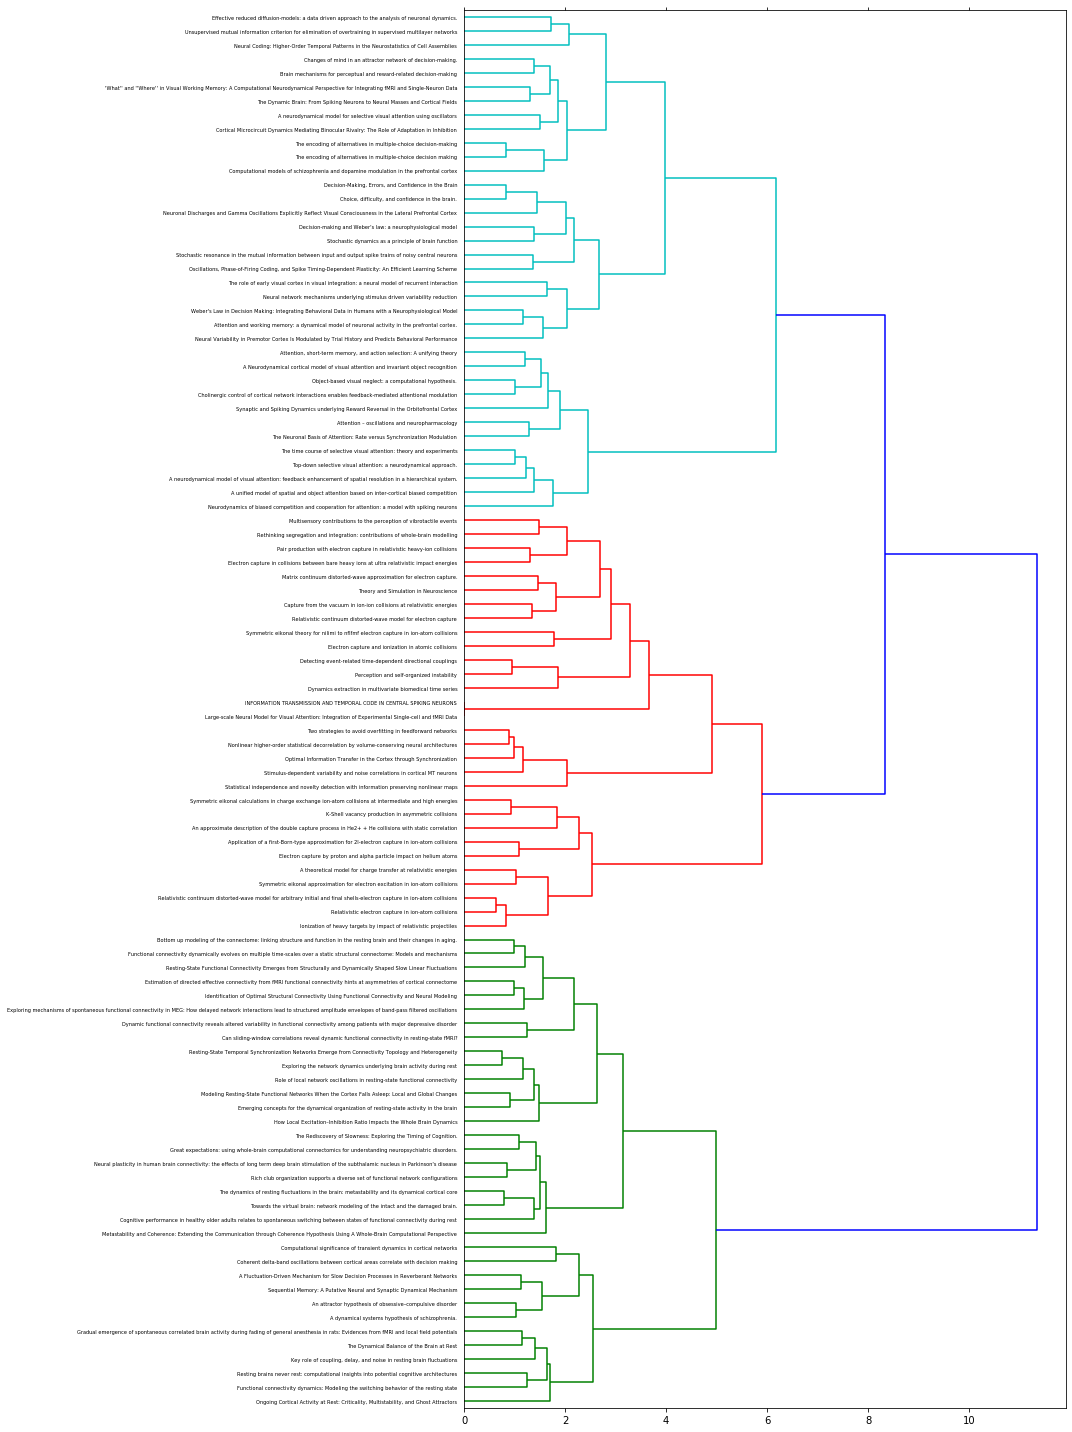

In [162]:
#using abstracts

tfidf_matrix = tfidf_vectorizer.fit_transform(abstracts) #fit the vectorizer to synopses
terms = tfidf_vectorizer.get_feature_names()
dist = 1 - cosine_similarity(tfidf_matrix)

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=list_titles); #<--- issue with labels, they're too long

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('GustavoDeco_labtree.png', dpi=200) #save figure as ward_clusters


In [134]:
# Using keywords

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
import scipy.cluster.hierarchy as hc
from scipy.spatial.distance import pdist,squareform
import seaborn as sns


vect = TfidfVectorizer(max_df = .8,lowercase=True, analyzer='word',stop_words= 'english',ngram_range=(1,1))
tfidf = vect.fit_transform(keywords)
distance_matrix = np.abs(1-(tfidf@tfidf.T).A)
np.fill_diagonal(distance_matrix,0)

count = CountVectorizer(max_df = .8,lowercase=True, analyzer='word',stop_words= 'english',ngram_range=(1,1))
cv_fit=count.fit_transform(keywords)



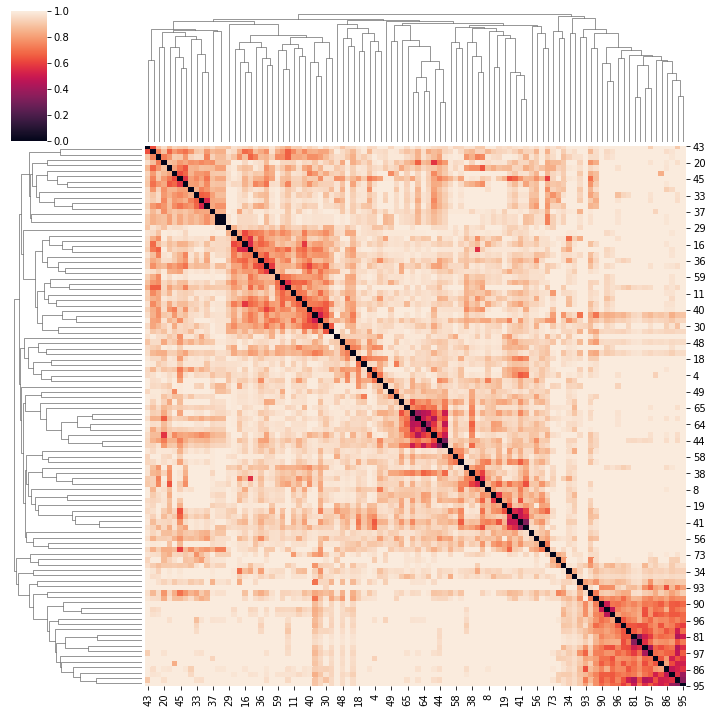

In [135]:
linkage = hc.linkage(squareform(distance_matrix), method='average')
sns.clustermap(distance_matrix, row_linkage=linkage, col_linkage=linkage)

In [148]:
## KEYWORDS 

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(keywords)]

max_epochs = 100
vec_size = 20
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('\riteration {0}'.format(epoch),end='\r')
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("\nModel Saved")

/usr/local/lib/python3.7/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
/usr/local/lib/python3.7/site-packages/gensim/models/base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


iteration 99
Model Saved


/usr/local/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11000. The TBB threading layer is disabled.
  warnings.warn(problem)


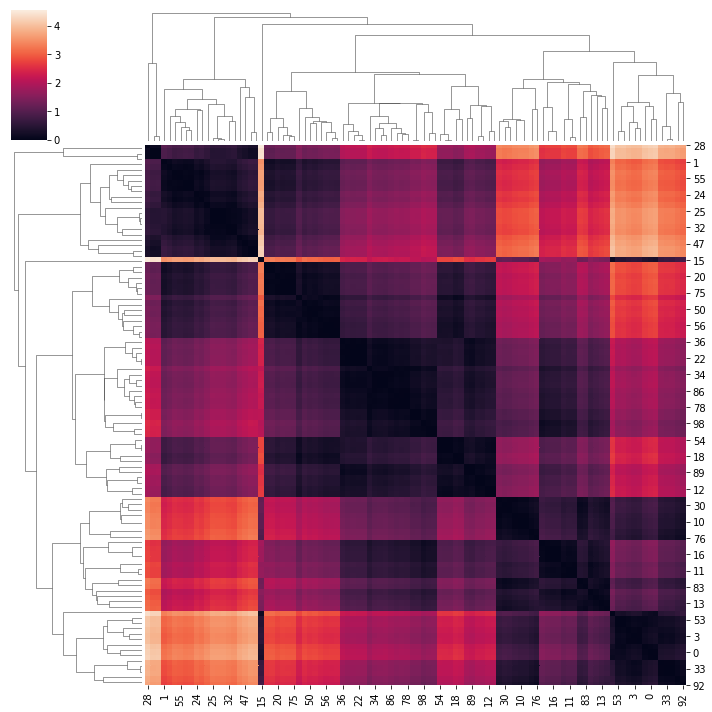

In [151]:
import umap

#load previously trained model
model= Doc2Vec.load("d2v.model")

#embed the documents
doc_space = np.zeros((len(keywords),20))
for i in range(len(keywords)):
    doc_space[i]=model.docvecs[str(i)]
    
#reduce dimensions UMAP
u = umap.UMAP(n_components=2,n_neighbors=10)
embedding=u.fit_transform(doc_space)
    
#compute new distance matrix, create clustering using the first component of UMAP space (or whatever number of components you choose)
distance_matrix=squareform(pdist(embedding[:,:1], metric='euclidean'))
linkage = hc.linkage(squareform(distance_matrix))
sns.clustermap(distance_matrix, row_linkage=linkage, col_linkage=linkage)

In [166]:
# Using abstracts

#clean the collected texts

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

texts = [i[1] for i in abstracts]
clean_text = [i.lower() for i in texts]
for i in range(len(texts)):
    clean_text[i] = ' '.join([word for word in texts[i].split() if word not in (stopwords.words('english'))])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sharonsheran/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sharonsheran/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [167]:
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(clean_text)]

max_epochs = 100
vec_size = 20
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('\riteration {0}'.format(epoch),end='\r')
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("\nModel Saved")

/usr/local/lib/python3.7/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
/usr/local/lib/python3.7/site-packages/gensim/models/base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


iteration 99
Model Saved


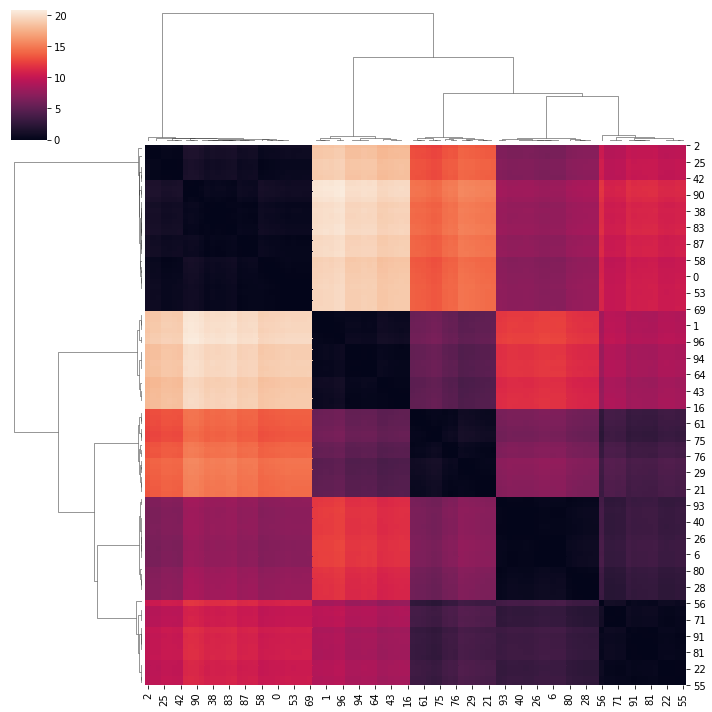

In [168]:
#load previously trained model
model= Doc2Vec.load("d2v.model")

#embed the documents
doc_space = np.zeros((len(texts),20))
for i in range(len(texts)):
    doc_space[i]=model.docvecs[str(i)]
    
#reduce dimensions UMAP
u = umap.UMAP(n_components=2,n_neighbors=10)
embedding=u.fit_transform(doc_space)
    
#compute new distance matrix, create clustering using the first component of UMAP space (or whatever number of components you choose)
distance_matrix=squareform(pdist(embedding[:,:1], metric='euclidean'))
linkage = hc.linkage(squareform(distance_matrix))
sns.clustermap(distance_matrix, row_linkage=linkage, col_linkage=linkage)

In [169]:
#make clusters using DBSCAN
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.48, min_samples=2).fit(embedding)
labels = db.labels_
from collections import Counter
Counter(labels)

Counter({0: 31, 1: 18, 2: 16, 3: 7, 4: 12, 5: 16})

In [175]:
#plot UMAP embedding using plotly, 3rd dimension represents time
import plotly.graph_objs as go


trace1 = go.Scatter3d(
    x=embedding[:,0],
    y=embedding[:,1],
    z=years,
    mode='markers',
    marker=dict(size=3,colorscale='Jet',colorbar=dict(title='clusters')),opacity=0.8)

fig = go.Figure(data=[trace1])
iplot(fig, filename='3d-scatter-colorscale')

In [185]:
import scipy.spatial as scs


# get data

#d = scs.distance.pdist(keywords) #<---- 2 DIMENSIONAL
#Z = sch.linkage(d, method='complete')



vect = TfidfVectorizer(max_df = .8,lowercase=True, analyzer='word',stop_words= 'english',ngram_range=(1,1))
tfidf = vect.fit_transform(keywords)
distance_matrix = np.abs(1-(tfidf@tfidf.T).A)
data_array = distance_matrix


# Initialize figure by creating upper dendrogram
fig = ff.create_dendrogram(distance_matrix, orientation='bottom', labels=labels)
for i in range(len(fig['data'])):
    fig['data'][i]['yaxis'] = 'y2'

# Create Side Dendrogram
dendro_side = ff.create_dendrogram(distance_matrix, orientation='right')
for i in range(len(dendro_side['data'])):
    dendro_side['data'][i]['xaxis'] = 'x2'

# Add Side Dendrogram Data to Figure
for data in dendro_side['data']:
    fig.add_trace(data)

# Create Heatmap
dendro_leaves = dendro_side['layout']['yaxis']['ticktext']
dendro_leaves = list(map(int, dendro_leaves))
data_dist = pdist(data_array)
heat_data = squareform(data_dist)
heat_data = heat_data[dendro_leaves,:]
heat_data = heat_data[:,dendro_leaves]

heatmap = [
    go.Heatmap(
        x = dendro_leaves,
        y = dendro_leaves,
        z = heat_data,
        colorscale = 'Blues'
    )
]

heatmap[0]['x'] = fig['layout']['xaxis']['tickvals']
heatmap[0]['y'] = dendro_side['layout']['yaxis']['tickvals']

# Add Heatmap Data to Figure
for data in heatmap:
    fig.add_trace(data)

# Edit Layout
fig.update_layout({'width':800, 'height':800,
                         'showlegend':False, 'hovermode': 'closest',
                         })
# Edit xaxis
fig.update_layout(xaxis={'domain': [.15, 1],
                                  'mirror': False,
                                  'showgrid': False,
                                  'showline': False,
                                  'zeroline': False,
                                  'ticks':""})
# Edit xaxis2
fig.update_layout(xaxis2={'domain': [0, .15],
                                   'mirror': False,
                                   'showgrid': False,
                                   'showline': False,
                                   'zeroline': False,
                                   'showticklabels': False,
                                   'ticks':""})

# Edit yaxis
fig.update_layout(yaxis={'domain': [0, .85],
                                  'mirror': False,
                                  'showgrid': False,
                                  'showline': False,
                                  'zeroline': False,
                                  'showticklabels': False,
                                  'ticks': ""
                        })
# Edit yaxis2
fig.update_layout(yaxis2={'domain':[.825, .975],
                                   'mirror': False,
                                   'showgrid': False,
                                   'showline': False,
                                   'zeroline': False,
                                   'showticklabels': False,
                                   'ticks':""})

# Plot!
fig.show()